In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import os
import sys
from pennylane import numpy as pnp
import torch
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from math import pi

In [ ]:
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.utils.logger import Logging
from src.utils.plotting import plot_results
from src.nn.pde import helmholtz_operator
from src.utils.plot_prediction import plt_prediction
from src.data.helmholtz_dataset import u, f

# from src.utils.color import model_color
# from src.utils.plot_loss import plot_loss_history

In [4]:
log_path = "../../testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

True

## Generate Testing Dataset


In [6]:
# Test data
num_points = 10
A1 = 1
A2 = 4
LAMBDA = 1.0

dom_coords = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32).to(DEVICE)

t = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)

x = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
t, x = torch.meshgrid(t.squeeze(), x.squeeze())
X_star = torch.hstack((t.flatten().unsqueeze(1), x.flatten().unsqueeze(1))).to(DEVICE)

/home/vlq26735/anaconda3/envs/pennylane0.29-sf/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Load trained model


In [7]:
model_path = "../../checkpoints/helmholtz/2025-01-23_17-58-36-294919/model.pth"  #

In [8]:
data = X_star
solver = "DV"

if solver == "CV":
    state = CVPDESolver.load_state(model_path)
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])
else:
    state = DVPDESolver.load_state(model_path)
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])


model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : , {len(state['loss_history'])}")
model.logger.print(f"The final loss : , {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")

Model state loaded from ../../checkpoints/helmholtz/2025-01-23_17-58-36-294919/model.pth


INFO:src.utils.logger:checkpoint path: self.log_path='../../testing_checkpoints/2025-01-31_14-05-53-042588'
INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 100, 'log_path': './checkpoints/helmholtz', 'input_dim': 2, 'output_dim': 1, 'num_qubits': 5, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [2, 50, 1], 'q_ansatz': 'alternating_layer_tdcnot', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'helmholtz', 'solver': 'DV', 'device': device(type='cuda'), 'method': 'non_gaussian', 'cutoff_dim': 3, 'class': 'DVQuantumLayer', 'ntype': 'two', 'encoding': 'amplitude'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 100
INFO:src.utils.logger:log_path : ./checkpoints/helmholtz
INFO:src.utils.logger:input_dim : 2
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logge

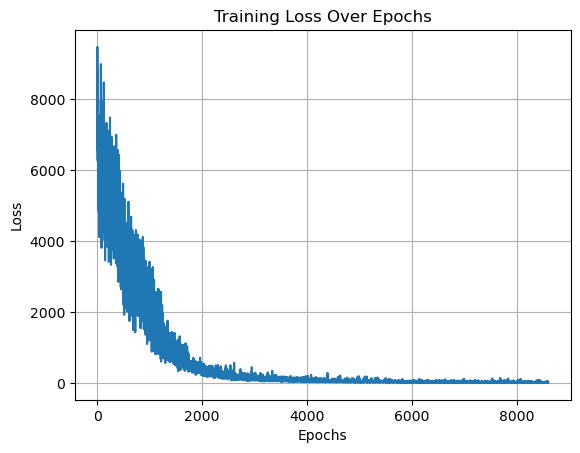

In [9]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

In [10]:
# Exact solution
u_star = u(X_star, A1, A2)
f_star = f(X_star, A1, A2, LAMBDA)


# Predictions
u_pred_star, f_pred_star = helmholtz_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_exact = u_star.cpu().detach().numpy()
f_exact = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()

INFO:src.utils.logger:The circuit used in the study:


The circuit is saved in ../../testing_checkpoints/2025-01-31_14-05-53-042588


In [17]:
# Relative L2 error
error_u = np.linalg.norm(u_pred - u_exact, 2) / np.linalg.norm(u_exact, 2) * 100
error_f = np.linalg.norm(f_pred - f_exact, 2) / np.linalg.norm(f_exact, 2) * 100
logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

INFO:src.utils.logger:Relative L2 error_u: 3.65e+01
INFO:src.utils.logger:Relative L2 error_f: 6.86e+00


In [12]:
# INFO:src.utils.logger:Relative L2 error_u: 3.25e+01
# INFO:src.utils.logger:Relative L2 error_f: 1.26e+01

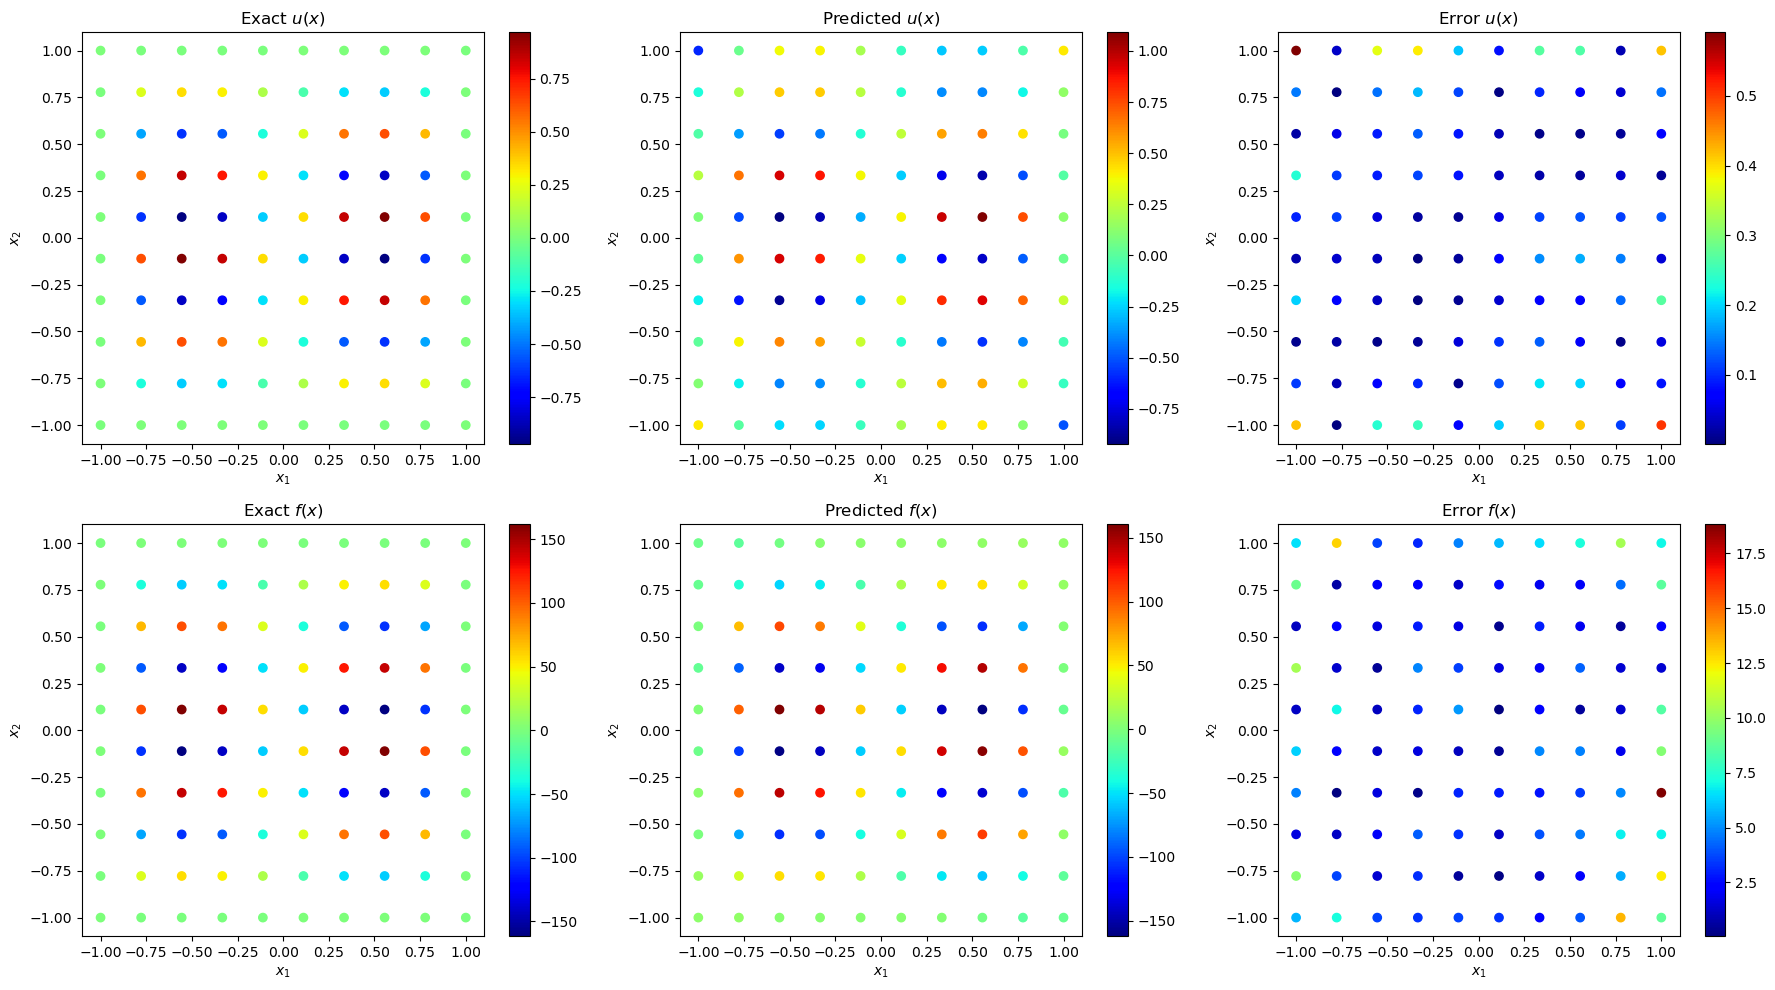

In [13]:
# Plot predictions
plt_prediction(
    logger,
    X,
    u_exact,
    u_pred,
    f_exact,
    f_pred,
)

In [14]:
model.parameters

<bound method Module.parameters of DVPDESolver(
  (preprocessor): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=32, bias=True)
  )
  (postprocessor): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
  (activation): Tanh()
  (quantum_layer): DVQuantumLayer()
  (loss_fn): MSELoss()
)>

In [15]:
# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 2158


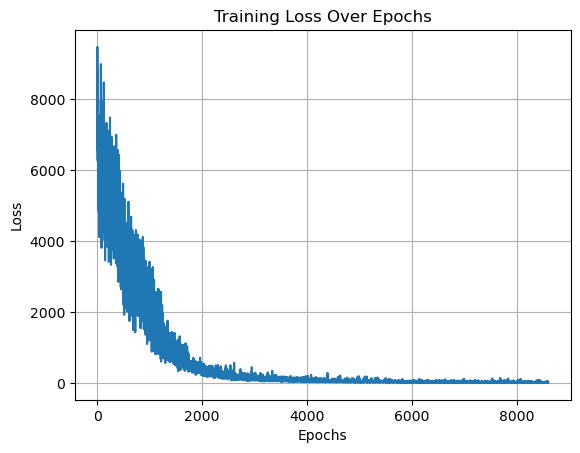

In [16]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)